## Implementing ResNet

In this notebook, I implement [ResNet](https://arxiv.org/pdf/1512.03385) and attempt to reproduce the paper authors' results on the CIFAR-10 dataset. With the 20 layer version I implemented I get approx. 10% error while they achieved 8.75% error. The  pad/random crop and random flip reduced the error by about 6%. The transforms along with the optimizer parameters, training instructions and batch size were all specified in the paper.

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.transforms as transforms

# Create Dataset

In [4]:
#I took data loader, visualisation and test code from here
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(nn.ZeroPad2d(4)),
     transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 46768871.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Explore Dataset

In [5]:
print(f"train dataset length : {len(trainset)}, test dataset length : {len(testset)}, image shape : {trainset[0][0].shape}, label type : {type(trainset[0][1])}")

train dataset length : 50000, test dataset length : 10000, image shape : torch.Size([3, 32, 32]), label type : <class 'int'>


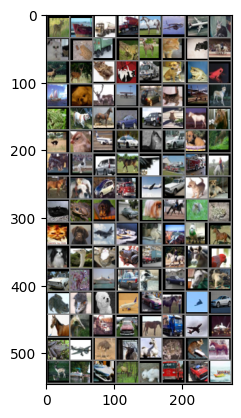

deer  ship  truck truck horse plane plane cat   cat   frog  truck frog  horse cat   cat   horse deer  deer  cat   cat   truck dog   frog  frog  ship  dog   deer  plane car   cat   plane dog   frog  dog   horse car   car   cat   horse horse bird  bird  plane car   deer  car   dog   deer  dog   horse car   horse plane truck truck horse horse dog   car   truck plane car   dog   dog   cat   frog  dog   car   dog   horse deer  frog  cat   dog   plane ship  cat   plane plane horse dog   bird  cat   frog  truck horse horse bird  car   deer  ship  car   bird  car   horse dog   frog  bird  dog   plane car   horse plane car   horse bird  truck car   horse truck plane plane frog  plane bird  deer  horse frog  cat   horse deer  ship  ship  deer  dog   truck car   ship 


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
#we can see the results of the zero padding/random transform in the below plot

## Network


In [7]:
class ResidualBlock(nn.Module):
  def __init__(self,in_channels,out_channels):
        super().__init__()
        self.in_channels,self.out_channels = in_channels,out_channels
        self.stride = 2 if in_channels!=out_channels else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3,padding=1, stride=self.stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #if we change shape of data in network, the residual layer will no longer be the same shape as the layer we are adding it to
        #so we must reshape it accordingly
        self.conv_res = nn.Conv2d(in_channels,out_channels, 1,stride=self.stride)
        self.bn_res = nn.BatchNorm2d(out_channels)

  def forward(self,input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        #if we have
        if self.in_channels!=self.out_channels:
          return F.relu(x + self.bn_res(self.conv_res((input))))

        return F.relu(x)



class Block(nn.Module):
  def __init__(self,in_channels,out_channels):
        super().__init__()

        self.resblock1 = ResidualBlock(in_channels,out_channels)
        self.resblock2 = ResidualBlock(out_channels,out_channels)
        self.resblock3 = ResidualBlock(out_channels,out_channels)

  def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        return x

#other resnet sizes simply have more layers in each block
class ResNet20(nn.Module):
  def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.block1 = Block(16,16)
        self.block2 = Block(16,32)
        self.block3 = Block(32,64)
        self.fc1 = nn.Linear(64,10)

  def forward(self,x):

        x = F.relu(self.bn1(self.conv1(x)))

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = F.avg_pool2d(x, x.shape[3])
        x = self.fc1(x.view(x.shape[0],-1))
        return x

## Train

In [8]:
criterion = nn.CrossEntropyLoss()
net = ResNet20().to(device)

In [13]:
optimizer = optim.SGD(net.parameters(),lr=0.1,weight_decay=0.0001,momentum = 0.9)

#we use iterations and epochs as the resnet paper describes training steps in iterations

iters = 0
running_loss = 0.0
epoch = 0

cont=True

#train for a single epoch (one full pass through data)
def train_one_epoch(net):

    #technically bad practice but this use case is simple enough that they shouldn't be a problem
    global iters
    global running_loss

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        iters+=1
        if iters == 32000 or iters==48000:

          for g in optimizer.param_groups:g['lr'] *=.10

        if iters == 64000:return False

        running_loss += loss.item()


    return True

while cont:
  epoch+=1
  cont = train_one_epoch(net)
  print(f'epoch: {str(epoch):>3} | iteration : {str(iters):>7} | loss: {str(int(running_loss)):>5}')

epoch:   1 | iteration :     391 | loss:   108
epoch:   2 | iteration :     782 | loss:   108
epoch:   3 | iteration :    1173 | loss:   110
epoch:   4 | iteration :    1564 | loss:   109
epoch:   5 | iteration :    1955 | loss:   108
epoch:   6 | iteration :    2346 | loss:   108
epoch:   7 | iteration :    2737 | loss:   107
epoch:   8 | iteration :    3128 | loss:   107
epoch:   9 | iteration :    3519 | loss:   107
epoch:  10 | iteration :    3910 | loss:   106
epoch:  11 | iteration :    4301 | loss:   106
epoch:  12 | iteration :    4692 | loss:   104
epoch:  13 | iteration :    5083 | loss:   109
epoch:  14 | iteration :    5474 | loss:   104
epoch:  15 | iteration :    5865 | loss:   105
epoch:  16 | iteration :    6256 | loss:   105
epoch:  17 | iteration :    6647 | loss:   106
epoch:  18 | iteration :    7038 | loss:   105
epoch:  19 | iteration :    7429 | loss:   102
epoch:  20 | iteration :    7820 | loss:   105
epoch:  21 | iteration :    8211 | loss:   104
epoch:  22 | 

## Test

In [14]:
def test(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images.to(device))
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.to(device)).sum().item()

  print(f'The accuracy of this network on the test images is: {(100 * correct / total):.2f} %')

In [15]:
test(net)

The accuracy of this network on the test images is: 90.64 %
